# Introduction to OpenCV

This is just a quick and easy introduction to some of the main functions you can use in opencv.
The task is to identify the shapes of the wooden blocks in the peg in hole game. Here, some basic image processing tools will be used:

1. Loading images
2. Filtering by colour
3. Edge Detection
4. Contour Extraction
5. Polygon Approximation
6. Drawing on Images
7. Saving Images

This is by no means the only way to solve the problem, so you can experiment with your own scripts if you'd like. However, if you are new to opencv and computer vision in general, hopefully this notebook gives you an idea about the tools you might have available if you're trying to extract features or solve some task involving images. 

For a more detailed tutorials, go to https://docs.opencv.org/3.1.0/d6/d00/tutorial_py_root.html

# Loading Images
We start off with an image that has already been cropped, for convenience. 

Import the necessary libraries. 
cv2, matplotlib, numpy, and scipy all need to be installed before running this script

If you are installing opencv from source, look here: 
https://docs.opencv.org/trunk/d7/d9f/tutorial_linux_install.html
Otherwise, you can install opencv via conda

True

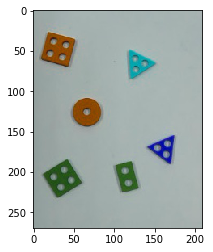

In [72]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy
import copy

# Display Matplotlib figures inline
%matplotlib inline

# Load the data. 
image = cv2.imread("test1.jpg")
plt.imshow(image)

# Note that opencv stores image data as BGR data (instead of RGB data)

# Filtering by Colour
We start of with an RGB image. The colours of the blocks are somewhat different and makes the job of detecting edges a little tricky (You can try it out yourself later. See what happens to the yellow triangle using the parameter values specified below). So what we first do is extract the wooden blocks by filtering.

In this image, the background of the image is white, so simple filtering by colour does the job pretty well.

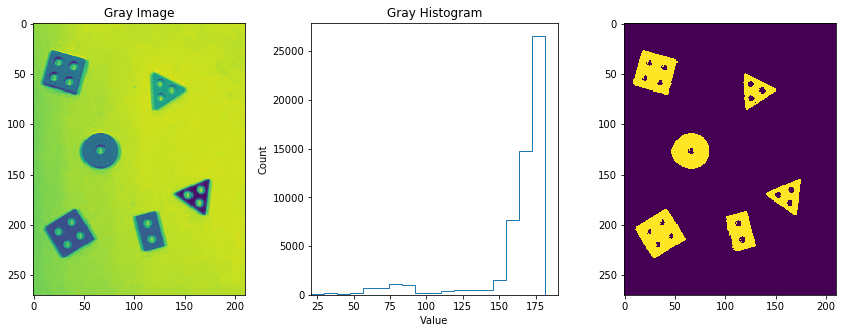

In [201]:
# Convert RGB Image to greyscale
img = copy.copy(image)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Create a zero mask, and filter out the shapes by colour
THRESHOLD = 130
gray_mask = np.zeros_like(gray)
gray_mask[gray<THRESHOLD] = 250

# Some graphs to show that this works and why
gray_flat = gray[np.isfinite(gray)]
black, white = np.min(gray_flat), np.max(gray_flat)

plt.figure('Gray Image and Histogram', figsize=(15, 5))
        
plt.subplot(1, 3, 1)
plt.imshow(gray)
plt.title('Gray Image')

plt.subplot(1,3,2)
plt.hist(gray_flat, bins=np.linspace(black,white, 20), histtype='step')
plt.xlim(black, white)
plt.title('Gray Histogram')
plt.xlabel('Value')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.imshow(gray_mask)
plt.show()

# Edge Detection
Now we have an image with clear boundaries for the wooden blocks.The Canny Edge detection algorithm involves finding the gradients of values between pixels, suppressing non-maximum values, then using hysteresis thresholding to extract edges. More info at: https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html
High gradients indicate an edge.

Two important things to note goes on here:
1. Blurring, i.e. smoothing. It is an important technique in image processing and acts to reduce noise, or as a Low Pass filter. More info here: https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
2. Dilation + Erosion. Erosion is useful for removing white noise, but requires Dilation to precede it because it shrinks the object. It is particularly useful for joining edges. https://docs.opencv.org/3.1.0/d9/d61/tutorial_py_morphological_ops.html

In this case, because we have used a mask, there is no need for step 2., since the gradients along the edges are high enough; however, in cases where edges are being extracted from the raw images, dilation+erosion is a useful technique for obtaining good contours. 

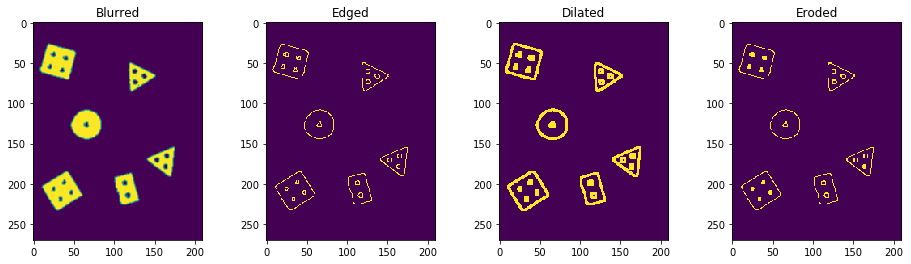

In [212]:
# Define the constants we'll be using below
MAX_THRESH = 60
MIN_THRESH = 250
BLUR = 3
DILATE = 1
ERODE = 1

# Blurring is an important technique in feature extraction.
# In this image, the most obvious effect is on the yellow triangle
#blurred = cv2.blur(copy.copy(gray_mask), (BLUR,BLUR))
#blurred = cv2.medianBlur(copy.copy(gray_mask), BLUR)
blurred = cv2.GaussianBlur(copy.copy(gray_mask), (BLUR, BLUR), 0)

# Perform Canny edge detection

edged = cv2.Canny(blurred, MIN_THRESH, MAX_THRESH)

# Perform a dilation + erosion to close gaps in between object edges
edged_dilated = cv2.dilate(edged, None, iterations=DILATE)
edged_eroded = cv2.erode(edged_dilated, None, iterations=ERODE)

# You can observe the effect of each step below
plt.figure(figsize=[16,4])
plt.subplot(1,4,1)
plt.title("Blurred")
plt.imshow(blurred)
plt.subplot(1,4,2)
plt.title("Edged")
plt.imshow(edged)
plt.subplot(1,4,3)
plt.title("Dilated")
plt.imshow(edged_dilated)
plt.subplot(1,4,4)
plt.title("Eroded")

plt.imshow(edged_eroded)

# Extracting Contours
Once you've extracted the edges, it is now time to find the contours.

`CNT_MODE = cv2.RETR_EXTERNAL` means that we only find external contours
i.e. we ignore contours formed by the inner circles. 

Don't worry too much about what hierarchy is for now, only the `cnts` value matters.

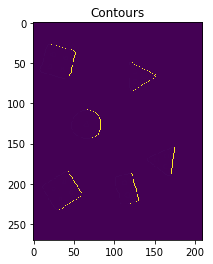

In [205]:
CNT_MODE = cv2.RETR_EXTERNAL

# Extract the contours
edged_img, cnts, hierarchy = cv2.findContours(edged.copy(), CNT_MODE, cv2.CHAIN_APPROX_SIMPLE)
plt.figure()
plt.title("Contours")
plt.imshow(edged_img)
plt.show()

The `cnts` variable stores information about the contours. In this case, we should expect 6 contours, which is the case

In [206]:
len(cnts)

6

# Polygon Approximation
So now we have our contours. All we need to do is figure out what shapes these contours are. Unfortunately, the contour values we get aren't simplified, so we can't just count the number of points and be done with that. Luckily there's a function in OpenCV that let's us do just that. 

More information here:

https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm, and

https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#approxpolydp


Since we'll be using it multiple times, create a function for it

In [207]:
def detect(cnt):
    # Find the perimeter
    peri = cv2.arcLength(cnt, True)
    
    # Approximate the shape. 
    approx = cv2.approxPolyDP(cnt, 0.032 * peri, True)
    return approx

And now, for each contour in `cnts`, we:
1. Filter out impossible contours based on size and perimeter
2. Find the shape centre
3. Determine what shape it is based on the number of approximated polygon points

Note that 1. and 2. aren't necessary for the task at hand, but are still useful to know about for other tasks.

In [208]:
shape_list = []
for i,c in enumerate(cnts):
    shape_object = {}
        
    # Ignore shapes that are too small. 
    # None of the contours in the test image should be affected by this though
    if cv2.contourArea(c) < 150:
        print "Too small"
        continue
    
    # Approximate the shape of the contour
    approx = detect(c)
    cmax = np.max(approx, axis = 0)
    cX, cY = cmax[0][0], cmax[0][1]

    # Ignore objects that are impossibly big
    peri = cv2.arcLength(c, True)
    if peri>300:
        print "Perimeter too big: ", peri
        continue
        
    # Find Shape Centre. Note again that the `approx` variable is a numpy array
    # So numpy arrays can be easily used for contour variables
    centre = np.mean(approx, axis=0)
    shape_object['centre']=centre
    
    # Determine the shape of the object by the number of approx points.
    if len(approx)==3:
        shape='Triangle'
        
    elif len(approx)==4:
        vect1 = approx[0]-approx[1]
        vect2 = approx[1]-approx[2]
        
        # Determine the length of the points. 
        len_side1 = scipy.linalg.norm(vect1)
        len_side2 = scipy.linalg.norm(vect2)
        
        aspect = float(len_side1)/len_side2

        if aspect < 1:
            aspect = 1/aspect
        if aspect>1.3:
            shape = 'Rectangle'
        else:
            shape = 'Square'
                
    elif len(approx) == 5:
        shape = 'Pentagon'

    else:
        shape = 'Circle'
        
    shape_object['shape']=shape
    shape_object['approx']=approx
    shape_object['centre']=centre[0][0], centre[0][1]
    
    shape_list.append(shape_object)


Just to show that the code work, let's plot out our objects on a matplotlib figure

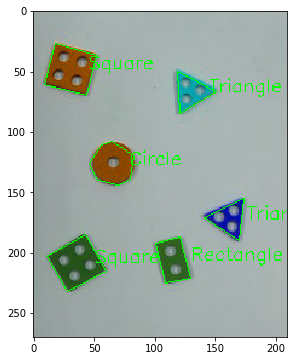

In [209]:
# Get a copy of our original image
show_img = copy.copy(img)

# For each shape, draw the contours, and put the text indicating the shape of the object
for shape in shape_list:
    cx, cy = shape['centre']
    cv2.drawContours(show_img, [shape['approx']], -1, (0,255,0), 1)
    cv2.putText(show_img, shape['shape'], (int(cx)+15,int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.figure(figsize=[6,6])
plt.imshow(show_img)

# Saving Images
Finally, let's save our image

In [213]:
# You can save image data to your workspace using:
cv2.imwrite("test1_labelled.jpg", show_img)

True